# Machine Learning Model
First we need to install PyTorch.

In [1]:
!pip install --upgrade torch torchvision tqdm

## Imports

In [2]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
hist_data: pd.DataFrame = pd.read_hdf("historical_daily_rainfall.hdf5", "rp").join(pd.read_hdf("historical_daily_rainfall.hdf5", "rif")).join(pd.read_hdf("historical_daily_rainfall.hdf5", "rm"))
hist_data

,rp,rph,rm
date,,,
2020-01-01,0.247712,0.425933,0.111560
2020-01-02,0.261731,0.441534,0.122300
2020-01-03,0.260025,0.434394,0.118907
2020-01-04,0.266463,0.389966,0.108461
2020-01-05,0.268371,0.394356,0.111303
...,...,...,...
2020-12-27,0.264331,0.381702,0.104140
2020-12-28,0.263833,0.382275,0.104072
2020-12-29,0.263035,0.381388,0.103959


In [5]:
combined_with_perc: pd.DataFrame = pd.read_hdf("combined_with_perc.hdf5", "model")
combined_with_perc = combined_with_perc.join(combined_with_perc[[f"E{i+1}" for i in range(51)]].apply(np.sort, axis=1, raw=True), rsuffix="_sort")
combined_with_hist = combined_with_perc.reset_index().merge(hist_data, left_on=[combined_with_perc.index.get_level_values(0).month, combined_with_perc.index.get_level_values(0).day], right_on=[hist_data.index.month, hist_data.index.day]).set_index(["date", "loc_nr"])
combined_with_hist.to_hdf("combined_with_perc_2.hdf5", "model")
combined_with_hist

,,key_0,key_1,det_run,E1,E2,E3,E4,E5,E6,E7,...,E45_sort,E46_sort,E47_sort,E48_sort,E49_sort,E50_sort,E51_sort,rp,rph,rm
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,3.0,0.200738,0.344863,0.071100
2017-04-01,260,4,1,26.0,25.0,25.0,31.0,15.0,41.0,11.0,14.0,...,36.0,38.0,41.0,41.0,42.0,50.0,54.0,0.200738,0.344863,0.071100
2018-04-01,260,4,1,36.0,32.0,40.0,16.0,31.0,26.0,35.0,32.0,...,46.0,47.0,49.0,51.0,55.0,60.0,71.0,0.200738,0.344863,0.071100
2019-04-01,260,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200738,0.344863,0.071100
2016-04-01,310,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.200738,0.344863,0.071100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31,310,3,31,6.0,15.0,4.0,25.0,6.0,15.0,14.0,8.0,...,25.0,27.0,27.0,28.0,29.0,31.0,32.0,0.201455,0.340566,0.070821
2019-03-31,310,3,31,0.0,1.0,4.0,0.0,2.0,2.0,2.0,2.0,...,8.0,8.0,8.0,9.0,11.0,13.0,15.0,0.201455,0.340566,0.070821
2017-03-31,240,3,31,0.0,2.0,7.0,5.0,8.0,0.0,8.0,0.0,...,8.0,9.0,10.0,10.0,14.0,18.0,30.0,0.201455,0.340566,0.070821


In [6]:
combined_with_perc: pd.DataFrame = pd.read_hdf("combined_with_perc.hdf5", "test")
combined_with_perc = combined_with_perc.join(combined_with_perc[[f"E{i+1}" for i in range(51)]].apply(np.sort, axis=1, raw=True), rsuffix="_sort")
combined_with_hist = combined_with_perc.reset_index().merge(hist_data, left_on=[combined_with_perc.index.get_level_values(0).month, combined_with_perc.index.get_level_values(0).day], right_on=[hist_data.index.month, hist_data.index.day]).set_index(["date", "loc_nr"])
combined_with_hist.to_hdf("combined_with_perc_2.hdf5", "test")
combined_with_hist

key_0  key_1  det_run    E1    E2    E3    E4    E5    E6  \
date       loc_nr                                                              
2020-01-01 260         1      1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2021-01-01 260         1      1      4.0   2.0   7.0   1.0   6.0   0.0   1.0   
2020-01-01 310         1      1      2.0   1.0   1.0   1.0   2.0   1.0   1.0   
2021-01-01 310         1      1     20.0  10.0   8.0  11.0   8.0   9.0  17.0   
2020-01-01 240         1      1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                  ...    ...      ...   ...   ...   ...   ...   ...   ...   
2020-12-31 310        12     31     11.0  12.0  20.0   9.0  15.0  15.0  19.0   
           240        12     31     10.0  11.0  17.0  24.0  19.0  24.0  13.0   
2021-04-02 260         4      2      0.0   0.0   1.0   0.0   2.0   0.0   1.0   
           310         4      2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
           240         4      2      1.0   0.0   1.0   1.0   0.0   1.0   1.0   

                     E7  ...  E45_sort  E46_sort  E47_sort  E48_sort  \
date       loc_nr        ...                                           
2020-01-01 260      0.0  ...       0.0       0.0       0.0       0.0   
2021-01-01 260      2.0  ...       6.0       7.0       7.0       7.0   
2020-01-01 310      0.0  ...       1.0       1.0       1.0       1.0   
2021-01-01 310     10.0  ...      19.0      20.0      23.0      25.0   
2020-01-01 240      0.0  ...       0.0       0.0       0.0       0.0   
...                 ...  ...       ...       ...       ...       ...   
2020-12-31 310     18.0  ...      23.0      24.0      24.0      25.0   
           240      6.0  ...      22.0      22.0      24.0      24.0   
2021-04-02 260      0.0  ...       1.0       1.0       1.0       1.0   
           310      0.0  ...       0.0       0.0       0.0       1.0   
           240      0.0  ...       1.0       1.0       1.0       2.0   

                   E49_sort  E50_sort  E51_sort        rp       rph        rm  
date       loc_nr                                                              
2020-01-01 260          0.0       0.0       0.0  0.247712  0.425933  0.111560  
2021-01-01 260          7.0       9.0      17.0  0.247712  0.425933  0.111560  
2020-01-01 310          2.0       2.0       2.0  0.247712  0.425933  0.111560  
2021-01-01 310         26.0      27.0      28.0  0.247712  0.425933  0.111560  
2020-01-01 240          0.0       0.0       1.0  0.247712  0.425933  0.111560  
...                     ...       ...       ...       ...       ...       ...  
2020-12-31 310         26.0      35.0      42.0  0.259229  0.383762  0.103646  
           240         24.0      24.0      28.0  0.259229  0.383762  0.103646  
2021-04-02 260          1.0       2.0       3.0  0.200707  0.344277  0.070681  
           310          1.0       1.0       4.0  0.200707  0.344277  0.070681  
           240          2.0       2.0       2.0  0.200707  0.344277  0.070681  

[1455 rows x 151 columns]

## Load Data Set

In [7]:
class RainDataset(Dataset):
    def __init__(self, data_type: str):
        combined_with_perc: pd.DataFrame = pd.read_hdf("combined_with_perc_2.hdf5", data_type)
        x = combined_with_perc[['det_run', 
        'is-260', 'is-310', 'is-240', 
        'DD', 'FH', 'T', 'P', 'N', 'U', 
        'rp', 'rph', 'rm'
        ] + [f"E{i + 1}_sort" for i in range(51)]].values
        y = combined_with_perc[["RH-fix"]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [8]:
model_dataset = RainDataset("model")
test_dataset = RainDataset("test")

In [9]:
train_dataloader = DataLoader(model_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Create model

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 32),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        params = self.linear_relu_stack(x)
        return params

model = NeuralNetwork()

## Loss function

In [11]:
learning_rate = 1e-4
batch_size = 32
epochs = 125

def opt_maape(pred, true):
    return torch.arctan(torch.abs((true - pred + 0.1)/(true + 0.1))).mean()

def opt_rmse(pred, true):
    return torch.sqrt(((true - pred) ** 2).mean())

def opt_meae(pred, true):
    return torch.median(torch.abs(true - pred))

def opt_mae(pred, true):
    return torch.mean(torch.abs(true - pred))

def opt_rmse_mean_median(pred, true):
    return 0.15 * opt_rmse(pred, true) + 0.35 * opt_mae(pred, true) + 0.5 * opt_meae(pred, true)

def opt_mrae(pred, true):
    return torch.sqrt(torch.abs(true - pred)).mean() ** 4

def opt_emape(pred, true: torch.Tensor):
    return torch.abs((true - pred)/torch.maximum(true, 2 * torch.ones(true.size()))).mean()

# loss_fn = nn.HuberLoss(delta=2)
loss_fn = nn.L1Loss()
# loss_fn = nn.MarginRankingLoss()
# loss_fn = opt_emape
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Run model

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 97.926338  [    0/ 4109]
loss: 63.510506  [ 3200/ 4109]
Epoch 2
-------------------------------
loss: 55.560669  [    0/ 4109]
loss: 40.739788  [ 3200/ 4109]
Epoch 3
-------------------------------
loss: 31.525536  [    0/ 4109]
loss: 23.107943  [ 3200/ 4109]
Epoch 4
-------------------------------
loss: 28.362442  [    0/ 4109]
loss: 14.282692  [ 3200/ 4109]
Epoch 5
-------------------------------
loss: 17.508726  [    0/ 4109]
loss: 9.989656  [ 3200/ 4109]
Epoch 6
-------------------------------
loss: 16.705868  [    0/ 4109]
loss: 9.603853  [ 3200/ 4109]
Epoch 7
-------------------------------
loss: 15.903309  [    0/ 4109]
loss: 7.417167  [ 3200/ 4109]
Epoch 8
-------------------------------
loss: 14.076783  [    0/ 4109]
loss: 6.680170  [ 3200/ 4109]
Epoch 9
-------------------------------
loss: 12.725962  [    0/ 4109]
loss: 5.807275  [ 3200/ 4109]
Epoch 10
-------------------------------
loss: 14.461412  [    0/ 4109]
loss: 5.080415 

In [14]:
combined_with_perc = pd.read_hdf("combined_with_perc_2.hdf5", "test")
combined_with_perc

key_0  key_1  det_run    E1    E2    E3    E4    E5    E6  \
date       loc_nr                                                              
2020-01-01 260         1      1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2021-01-01 260         1      1      4.0   2.0   7.0   1.0   6.0   0.0   1.0   
2020-01-01 310         1      1      2.0   1.0   1.0   1.0   2.0   1.0   1.0   
2021-01-01 310         1      1     20.0  10.0   8.0  11.0   8.0   9.0  17.0   
2020-01-01 240         1      1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                  ...    ...      ...   ...   ...   ...   ...   ...   ...   
2020-12-31 310        12     31     11.0  12.0  20.0   9.0  15.0  15.0  19.0   
           240        12     31     10.0  11.0  17.0  24.0  19.0  24.0  13.0   
2021-04-02 260         4      2      0.0   0.0   1.0   0.0   2.0   0.0   1.0   
           310         4      2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   
           240         4      2      1.0   0.0   1.0   1.0   0.0   1.0   1.0   

                     E7  ...  E45_sort  E46_sort  E47_sort  E48_sort  \
date       loc_nr        ...                                           
2020-01-01 260      0.0  ...       0.0       0.0       0.0       0.0   
2021-01-01 260      2.0  ...       6.0       7.0       7.0       7.0   
2020-01-01 310      0.0  ...       1.0       1.0       1.0       1.0   
2021-01-01 310     10.0  ...      19.0      20.0      23.0      25.0   
2020-01-01 240      0.0  ...       0.0       0.0       0.0       0.0   
...                 ...  ...       ...       ...       ...       ...   
2020-12-31 310     18.0  ...      23.0      24.0      24.0      25.0   
           240      6.0  ...      22.0      22.0      24.0      24.0   
2021-04-02 260      0.0  ...       1.0       1.0       1.0       1.0   
           310      0.0  ...       0.0       0.0       0.0       1.0   
           240      0.0  ...       1.0       1.0       1.0       2.0   

                   E49_sort  E50_sort  E51_sort        rp       rph        rm  
date       loc_nr                                                              
2020-01-01 260          0.0       0.0       0.0  0.247712  0.425933  0.111560  
2021-01-01 260          7.0       9.0      17.0  0.247712  0.425933  0.111560  
2020-01-01 310          2.0       2.0       2.0  0.247712  0.425933  0.111560  
2021-01-01 310         26.0      27.0      28.0  0.247712  0.425933  0.111560  
2020-01-01 240          0.0       0.0       1.0  0.247712  0.425933  0.111560  
...                     ...       ...       ...       ...       ...       ...  
2020-12-31 310         26.0      35.0      42.0  0.259229  0.383762  0.103646  
           240         24.0      24.0      28.0  0.259229  0.383762  0.103646  
2021-04-02 260          1.0       2.0       3.0  0.200707  0.344277  0.070681  
           310          1.0       1.0       4.0  0.200707  0.344277  0.070681  
           240          2.0       2.0       2.0  0.200707  0.344277  0.070681  

[1455 rows x 151 columns]

In [15]:
import time
def rmse(true, predicted):
    return np.sqrt(((true - predicted) ** 2).mean())

def mae(true, predicted):
    return np.abs(true - predicted).mean()

# def smae(true, predicted):
#     return (np.abs(true - predicted)/((np.abs(predicted) + np.abs(true))/2)).mean()

# def maape(true, pred):
#     return np.arctan(np.abs((true - pred + 0.1)/(true + 0.1))).mean()

def meae(true, pred):
    return np.median(np.abs(true - pred))

def me(true, pred):
    return (true - pred).mean()

# def mrae(true, pred):
#     return np.sqrt(np.abs(true - pred)).mean()

def malipe(true, pred):
    return (np.abs(true - pred)/np.maximum(true, 0.5)).mean()

def get_error_statistics(true, pred, bins=10):
    time_ = int(time.time())
    print(f"RMSE: {rmse(true, pred)}")
    print(f"MAE: {mae(true, pred)}")
    print(f"MeAE: {meae(true, pred)}")
    print(f"ME: {me(true, pred)}")
    print(f"MALiPE: {malipe(true, pred)}")

    print("Histogram:")
    plt.hist(true - pred, bins=bins, density=True, range=[1.5 * np.quantile(true - pred, 0.05), 1.5 * np.quantile(true - pred, 0.95)])
    plt.title("Error histogram")
    plt.xlabel("Error (10 mm)")
    plt.ylabel("Frequency")
    plt.savefig(f"plots/{time_}ErrorHist.png")
    plt.show()

    print("Scatter plot:")
    plt.scatter(true, true-pred)
    plt.title("Error Scatter Plot")
    plt.xlabel("True Rainfall (10 mm)")
    plt.ylabel("Error (10 mm)")
    plt.ylim([-np.abs(true - pred).max() * 1.1, np.abs(true - pred).max() * 1.1])
    plt.savefig(f"plots/{time_}ScatterPlot.png")
    plt.show()

    print("Error-Quantile plot:")
    x = np.linspace(0.025, 0.975, 1000)
    plt.plot(x, np.quantile(true - pred, x))
    plt.title("Error Quantile Plot")
    plt.xlabel("Quantile")
    plt.ylabel("Error (10mm)")
    plt.savefig(f"plots/{time_}ErrorQuantile.png")
    plt.show()

RMSE: 28.09385717538626
MAE: 10.605893102093251
MeAE: 1.4045771360397339
ME: 4.961966650139793
MALiPE: 1.138491150836105
Histogram:


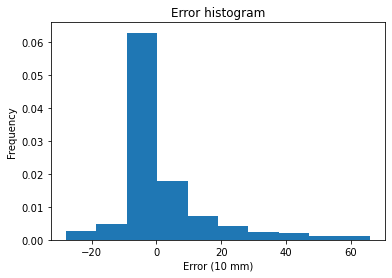

Scatter plot:


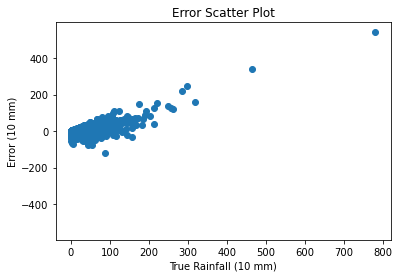

Error-Quantile plot:


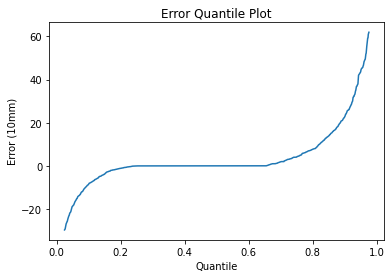

In [16]:
x = torch.tensor(combined_with_perc[['det_run', 
        'is-260', 'is-310', 'is-240', 
        'DD', 'FH', 'T', 'P', 'N', 'U', 
        'rp', 'rph', 'rm'
        ] + [f"E{i + 1}_sort" for i in range(51)]].values, dtype=torch.float32)

model.eval()
y_hat = model(x).detach().numpy().transpose()[0]
y = combined_with_perc["RH-fix"].values

get_error_statistics(y, y_hat)